In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import statsmodels.tsa.stattools as st
import json
warnings.filterwarnings("ignore")

In [2]:
def Remove_Outlier_Indices(df):
    Q1 = df.quantile(0.1)
    Q3 = df.quantile(0.9)
    IQR = Q3 - Q1
    trueList = ~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR)))
    return trueList

In [3]:
FOLDER_PATH = 'data/'
DATA_COLUMNS = ['wiki_movie_id', 'freebase_movie_id', 'movie_name',
       'movie_box_office_revenue', 'movie_runtime', 'languages', 'countries',
       'genres', 'imdb_id', 'cast', 'rating', 'votes', 'budget', 'plot',
       'characters_names', 'main_character', 'release_year']
df = pd.read_csv(FOLDER_PATH + 'movie_processed.csv', names=DATA_COLUMNS, header=0, index_col=0, parse_dates=['release_year'])
df.head()

,wiki_movie_id,freebase_movie_id,movie_name,movie_box_office_revenue,movie_runtime,languages,countries,genres,imdb_id,cast,rating,votes,budget,plot,characters_names,main_character,release_year
0,975900,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,['English'],['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv...",228333.0,"['Natasha Henstridge', 'Ice Cube', 'Jason Stat...",4.9,55370.0,28000000.0,"Set in the second half of the 22nd century, th...","['Akooshay', 'Lieutenant Melanie Ballard', 'De...",Lieutenant Melanie Ballard,2001.0
1,9363483,/m/0285_cd,White Of The Eye,NaN,110.0,['English'],['United Kingdom'],"['Thriller', 'Erotic thriller', 'Psychological...",NaN,NaN,NaN,NaN,NaN,A series of murders of rich young women throug...,[],NaN,1987.0
2,261236,/m/01mrr1,A Woman in Flames,NaN,106.0,['German'],['Germany'],['Drama'],83949.0,"['Gudrun Landgrebe', 'Mathieu Carrière', 'Hann...",6.0,591.0,NaN,"Eva, an upper class housewife, becomes frustra...",[],NaN,1983.0
3,18998739,/m/04jcqvw,The Sorcerer's Apprentice,NaN,86.0,['English'],['South Africa'],"['Family Film', 'Fantasy', 'Adventure', 'World...",NaN,NaN,NaN,NaN,NaN,"Every hundred years, the evil Morgana returns...",['Morgana'],Morgana,2002.0
4,6631279,/m/0gffwj,Little city,NaN,93.0,['English'],['United States of America'],"['Romantic comedy', 'Ensemble Film', 'Comedy-d...",NaN,NaN,NaN,NaN,NaN,"Adam, a San Francisco-based artist who works a...","['Rebecca', 'Nina']",Nina,1997.0


<AxesSubplot:>

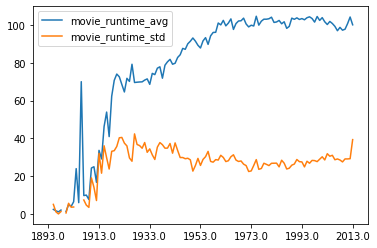

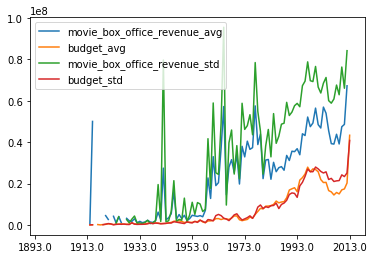

In [33]:
def yearly_avg(df, cols):
    df = df[Remove_Outlier_Indices(df)]
    df_avg = [y for y in df['release_year'].unique() if not pd.isnull(y)]
    df_avg.sort()
    df_avg = pd.DataFrame(np.array([df_avg] * (2*len(cols))).T, index = df_avg, columns=[col+'_avg' for col in cols]+[col+'_std' for col in cols])
    for i, row in df_avg.iterrows():
        for col in cols:
            row[col+'_avg'] = df[df['release_year'] == i][col].mean()
            row[col+'_std'] = df[df['release_year'] == i][col].std()
    return df_avg


yearly_avg(df, ['movie_runtime']).plot()
yearly_avg(df, ['movie_box_office_revenue','budget']).plot()


In [34]:
def test_granger(df, cols, maxlag):
    st.grangercausalitytests(yearly_avg(df, cols)[list(map(lambda x: x+'_avg', cols))].dropna(), maxlag=maxlag)
    
test_granger(df, ['movie_box_office_revenue', 'movie_runtime'], 10)
test_granger(df, ['movie_box_office_revenue', 'budget'], 10)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.0027  , p=0.0865  , df_denom=90, df_num=1
ssr based chi2 test:   chi2=3.1028  , p=0.0782  , df=1
likelihood ratio test: chi2=3.0522  , p=0.0806  , df=1
parameter F test:         F=3.0027  , p=0.0865  , df_denom=90, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3534  , p=0.7033  , df_denom=87, df_num=2
ssr based chi2 test:   chi2=0.7474  , p=0.6882  , df=2
likelihood ratio test: chi2=0.7444  , p=0.6892  , df=2
parameter F test:         F=0.3534  , p=0.7033  , df_denom=87, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.4129  , p=0.0062  , df_denom=84, df_num=3
ssr based chi2 test:   chi2=14.3420 , p=0.0025  , df=3
likelihood ratio test: chi2=13.3181 , p=0.0040  , df=3
parameter F test:         F=4.4129  , p=0.0062  , df_denom=84, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.1753  , p=0.0791  , df_d

In [74]:
def count_col_by_year(years, col, normalized=False):
    elems = set()
    for i in col:
        elems.update(eval(i))
    years_unique = [y for y in years.unique() if not pd.isnull(y)]
    years_unique.sort()
    df_cnt = pd.DataFrame(np.array([[0]*len(years_unique)]*len(elems)).T, index = years_unique, columns=list(elems))
    for y in years_unique:
        matched = col[years == y]
        for i in matched:
            for j in eval(i):
                df_cnt[j][y] += 1
        if normalized:
            df_cnt.loc[y] = df_cnt.loc[y]/len(matched)
    return df_cnt
    
genre_count = count_col_by_year(df['release_year'], df['genres'], normalized = True)
genre_count.head()

,Comedy-drama,Comedy film,Kitchen sink realism,Political satire,Comedy Western,Gender Issues,Jungle Film,Pornography,Heavenly Comedy,Period piece,...,Reboot,Anthropology,Road movie,Giallo,Chase Movie,Drama,Horse racing,Mystery,Domestic Comedy,Marriage Drama
1893.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1894.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1895.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1896.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1897.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
genre_max = pd.concat({"genre":genre_count.idxmax(axis=1),"cnt":genre_count.max(axis=1)}, axis = 1)
genre_max

,genre,cnt
1893.0,Indie,1.000000
1894.0,Indie,1.000000
1895.0,Indie,1.000000
1896.0,Silent film,0.833333
1897.0,Silent film,0.750000
...,...,...
2010.0,Drama,0.483261
2011.0,Drama,0.481067
2012.0,Drama,0.367069
2013.0,Drama,0.357143


Indie


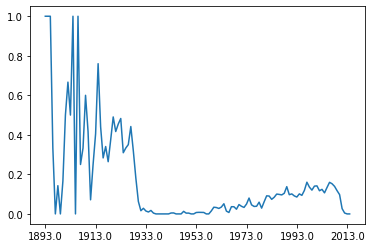

Silent film


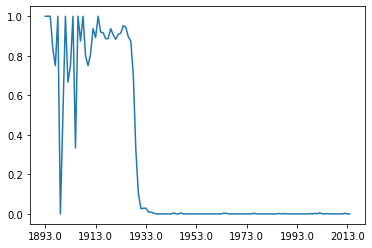

Short Film


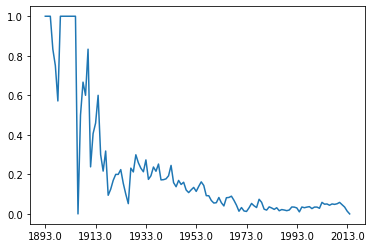

Biographical film


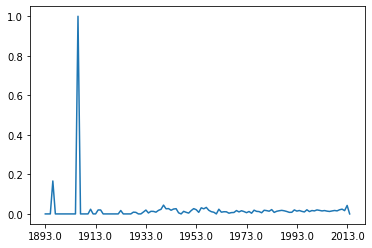

Black-and-white


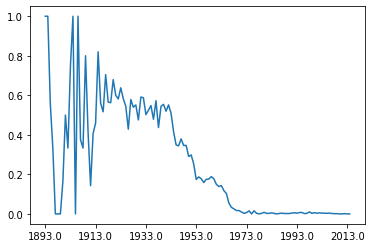

Drama


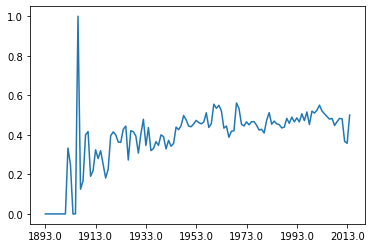

In [81]:
for i in genre_max["genre"].unique():
    print(i)
    genre_count[i].plot()
    plt.show()